In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import gym
import collections
import random

In [7]:
def create_new_batch(env, act=-1):
    if act==-1:
        img_1 = composed(env.render(mode='rgb_array')) 
        env.step(0)
        img_2 = composed(env.render(mode='rgb_array') )
        env.step(1)
        img_3 = composed(env.render(mode='rgb_array') )
        env.step(0)
        img_4 = composed(env.render(mode='rgb_array') )
    else:
        img_1 = composed(env.render(mode='rgb_array') )
        env.step(act)
        img_2 = composed(env.render(mode='rgb_array') )
        env.step(act)
        img_3 = composed(env.render(mode='rgb_array') )
        env.step(act)
        img_4 = composed(env.render(mode='rgb_array') ) 
    return torch.stack([img_1,img_2,img_3,img_4])

In [8]:
mem = collections.namedtuple('Mem', ['state', 'action','reward', 'future_state'])
class experience_replay:
    def __init__(self, N):
        self.i=0
        self.replay=[]
        self.mem_len=N
    
    def add_mem(self, state,action,reward,future_state):
        if len(self.replay)<self.mem_len:
            self.replay.append(mem(state,action,reward,future_state))
            self.i=(self.i+1)%self.mem_len
            return
        else:
            self.replay[self.i]=mem(state,action,reward,future_state)
            self.i=(self.i+1)%self.mem_len
    
    def sample_batch(self, batch_size):
        return random.sample(self.replay, batch_size)
    
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(-1)
        return x
composed = torchvision.transforms.Compose([ torchvision.transforms.ToPILImage(),
                                            torchvision.transforms.Grayscale(1),
                                            torchvision.transforms.Resize((110,84)),
                                            torchvision.transforms.CenterCrop((84,84)),
                                            torchvision.transforms.ToTensor()])
model= torch.nn.Sequential( 
    torch.nn.Conv2d(1, 16, (8,8), stride=4), 
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, (4,4), stride=2), 
    torch.nn.ReLU(),
    Flatten(),
    torch.nn.Linear(10368, 2)
)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [16]:
D=50
M=10
T=50
epsilon=.05
gamma=.9
env=gym.make('CartPole-v0')
er=experience_replay(D)
reward_ls=[]
env.reset()

array([0.0429449 , 0.0175491 , 0.01861743, 0.02821507])

In [17]:
for eps in range(M):
    env.reset()
    batch=create_new_batch(env, act=-1)
    for t in range(T):
        
        if random.random()<epsilon:
            act=env.action_space.sample()  
        else:
            Q=model(batch).data.numpy()
            print(Q)
            act=np.argmax(Q[0])
        _, reward, done, _=env.step(act)
        reward_ls.append(reward)
        new_batch=create_new_batch(env, act=act)
        if done:
            er.add_mem(batch, act, reward, False)
        else:
            er.add_mem(batch, act, reward, new_batch)
        batch=new_batch
        optimizer.zero_grad()
        for k in range(4): 
            rnd_mini_batch=er.sample_batch(1)[0]
            if hasattr(rnd_mini_batch.future_state,"shape"):
                y=rnd_mini_batch.reward+gamma*model(rnd_mini_batch.future_state)
            else:
                y=rnd_mini_batch.reward
            loss=torch.sum((y-model(rnd_mini_batch.state))**2)
            loss.backward()
        optimizer.step()

[0.02204555 0.02204555]
[0.03229502 0.03229502]
[0.04949372 0.04949372]
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
[0.08995298 0.08995298]
[0.14673221 0.14673221]
[0.21590555 0.21590555]
[0.27971387 0.27971387]
[0.3223026 0.3223026]
[0.36322984 0.36322984]
[0.34832403 0.34832403]
[0.30894116 0.30894116]
[0.26878127 0.26878127]
[0.21113488 0.21113488]
[0.14236236 0.14236236]
[0.06907809 0.06907809]
[0.017596 0.017596]
[-0.03014555 -0.03014555]
[-0.05070131 -0.05070131]
[-0.04514538 -0.04514538]
[-0.0354273 -0.0354273]
[-0.00384685 -0.00384685]
[0.04488331 0.04488331]
[0.08803847 0.08803847]
[0.12357821 0.12357821]
[0.1545714 0.1545714]
[0.17009957 0.17009957]
[0.17046696 0.17046696]
[0.15716025 0.15716025]
[0.1326114 0.1326114]
[0.09990851 0.09990851]
[0.06248324 0.06248324]
[0.02380183 0.02380183]
[-0.01044431 -0.01044431]
[-0.0

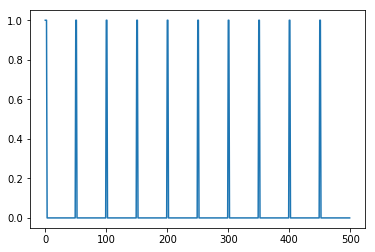

In [18]:
plt.plot(reward_ls)